In [1]:
import os
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

from file_paths import RAW_DATA_PATH, FIGURE_PATH, EVAL_PATH, OUTPUT_PATH
from utils.visualization import generate_skeleton_plot_one_frame

In [2]:
LABEL_DICT = {"NONE": 0, "Jump": 1, "Spin": 2, "Sequence": 0}
CUSTOM_MAP = mcolors.ListedColormap(["lightblue", "green", "yellow"])

### Raw Data Summary Statistics

In [3]:
### load labels for all files
labels_all = []
for file in os.listdir(os.path.join(RAW_DATA_PATH, "labels")):
    with open(
        os.path.join(RAW_DATA_PATH, "labels", file),
        "r",
    ) as f:
        labels = f.read().splitlines()
        labels_all.append(labels)

##### Number of frames & jumps & spins per video

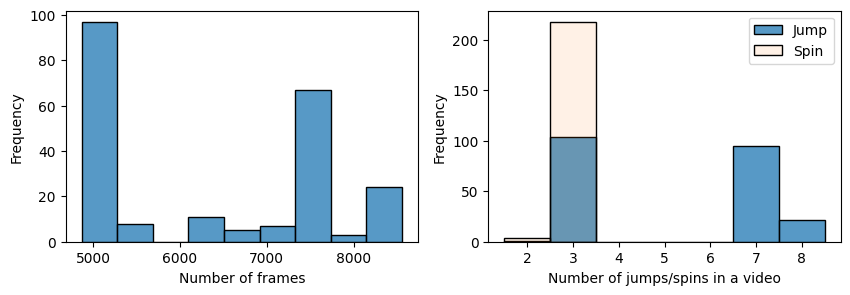

In [4]:
def count_jump_or_spin(labels, target_element):
    count = 0
    previous_element = "NONE"
    
    for element in labels:
        if element == target_element and previous_element != target_element:
            count += 1
        previous_element = element
        
    return count


frame_counts = [len(labels) for labels in labels_all]
jump_counts = [count_jump_or_spin(labels, "Jump") for labels in labels_all]
spin_counts = [count_jump_or_spin(labels, "Spin") for labels in labels_all]

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
sns.histplot(frame_counts, ax = ax1)
ax1.set_xlabel("Number of frames")
ax1.set_ylabel("Frequency")

sns.histplot(jump_counts, ax = ax2, label = "Jump", discrete=True)
sns.histplot(spin_counts, ax = ax2, label = "Spin", discrete=True, alpha=0.1)
ax2.set_xlabel("Number of jumps/spins in a video")
ax2.set_ylabel("Frequency")
ax2.legend()
fig.savefig(os.path.join(FIGURE_PATH, "frame_element_count.png"), bbox_inches="tight")

##### Duration of a jump/spin

The average number of frames for a jump is 158.20, which is about 5.27 seconds.
The average number of frames for a spin is 413.77, which is about 13.79 seconds.


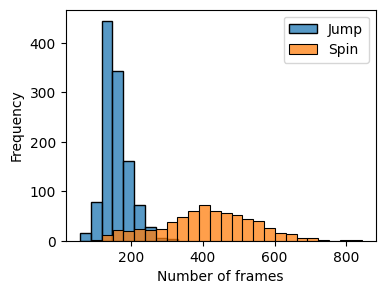

In [5]:
def compute_duration(labels, target_element):
    durations = []
    previous_element = "NONE"
    
    for i, element in enumerate(labels):
        if element == target_element and previous_element != target_element:
            start_time = i
        elif element != target_element and previous_element == target_element:
            end_time = i
            duration = end_time - start_time
            durations.append(duration)
        previous_element = element
    
    if element == target_element:
        durations.append(len(labels) - start_time)
            
    return durations

jump_durations = [compute_duration(labels, "Jump") for labels in labels_all]
spin_durations = [compute_duration(labels, "Spin") for labels in labels_all]
jump_durations = [item for duration in jump_durations for item in duration]
spin_durations = [item for duration in spin_durations for item in duration]

print(
    f"The average number of frames for a jump is {np.mean(jump_durations):.2f}, "
    f"which is about {np.mean(jump_durations)/30:.2f} seconds."
)
print(
    f"The average number of frames for a spin is {np.mean(spin_durations):.2f}, "
    f"which is about {np.mean(spin_durations)/30:.2f} seconds."
)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 3))
sns.histplot(jump_durations, binwidth=30, label = "Jump", ax = ax)
sns.histplot(spin_durations, binwidth=30, label = "Spin", ax = ax)
ax.set_xlabel("Number of frames")
ax.set_ylabel("Frequency")
ax.legend()
fig.savefig(os.path.join(FIGURE_PATH, "element_duration.png"), bbox_inches="tight")

### Skeleton Example

##### Jump and spin frame examples

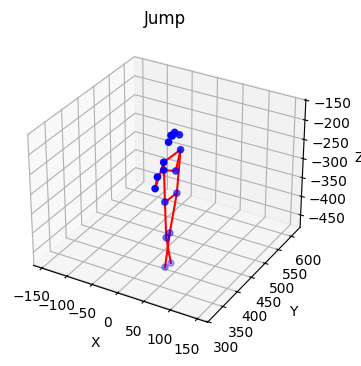

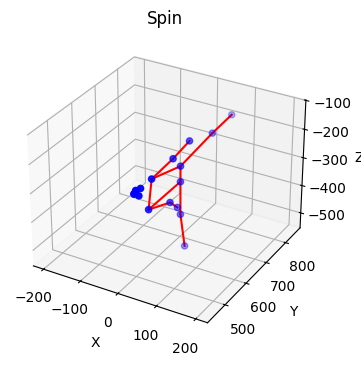

In [6]:
feature_example = np.load(os.path.join(RAW_DATA_PATH, "features", "n02_p08.npy"))
feature_example = feature_example[:, :, [2, 0, 1]]
feature_example[:, : , 2] *= -1
with open(
        os.path.join(RAW_DATA_PATH, "labels", "n02_p08.txt"),
        "r",
    ) as f:
        label_example = f.read().splitlines()

generate_skeleton_plot_one_frame(feature_example[893], label_example[893], "jump_example.png")
generate_skeleton_plot_one_frame(feature_example[1353], label_example[1353], "spin_example.png")

##### Element distribution in a routine

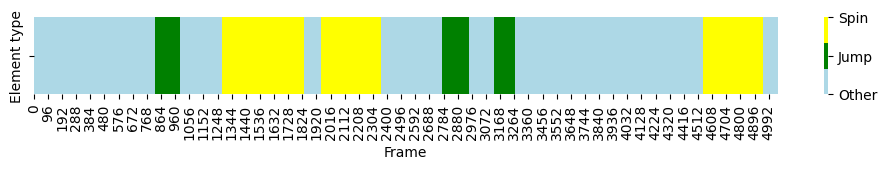

In [7]:
label_example_numeric = np.array([LABEL_DICT[i] for i in label_example]).reshape(1, -1)
label_example = np.array(label_example).reshape(1, -1)

# Create the heatmap with numerical data and string annotations
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 1))
sns.heatmap(label_example_numeric, cmap=CUSTOM_MAP, cbar=True, ax = ax)

# legend labels
cbar = ax.collections[0].colorbar
cbar.set_ticks([0, 1, 2])
cbar.set_ticklabels(['Other', 'Jump', 'Spin'])

ax.set_yticklabels(["Element type"])
ax.set_xlabel("Frame")

fig.savefig(os.path.join(FIGURE_PATH, "element_distribution_example.png"), bbox_inches="tight")

### Performance Evaluation (Run it after the pipeline)

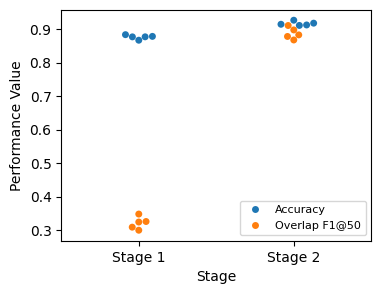

In [8]:
performances = []
for i in range(5):
    with open(os.path.join(EVAL_PATH, f"performance_{i}.json"), 'r') as file:
        data = pd.DataFrame(json.load(file))
        data["source"] = i
        performances.append(data)
    
performances = pd.concat(performances).reset_index()
performances.rename(columns = {"index": "Metrics"}, inplace = True)
performances = pd.melt(performances, 
  id_vars=['Metrics', 'source'], 
  value_vars=['Stage 1', 'Stage 2'],
  var_name='Stage', 
  value_name='Performance Value')

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 3))
sns.swarmplot(data=performances, x="Stage", y="Performance Value", hue="Metrics", ax = ax)
ax.legend(fontsize=8)
fig.savefig(os.path.join(FIGURE_PATH, "performance_plot.png"), bbox_inches="tight")

### Visualize Perdictions for An Example (Run it after the pipeline)

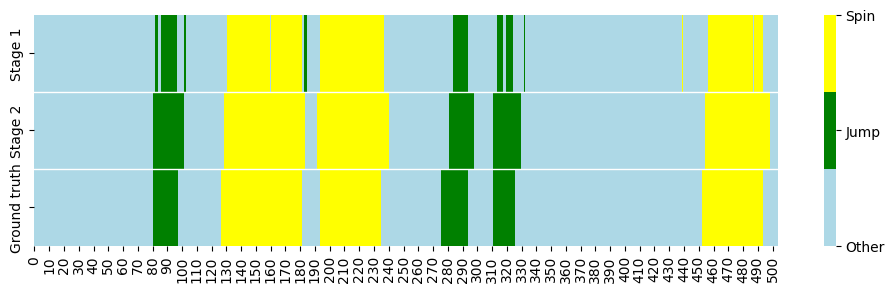

In [9]:
stage1 = np.load(os.path.join(OUTPUT_PATH, "stage1", "n02_p08_0.npy"))
stage2 = np.load(os.path.join(OUTPUT_PATH, "stage2", "n02_p08_0.npy"))
gt = np.load(os.path.join(OUTPUT_PATH, "ground_truth", "n02_p08_0.npy"))
df = pd.DataFrame({"Stage 1": stage1, "Stage 2": stage2, "Ground truth": gt}).T

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 3))
sns.heatmap(df, cmap = CUSTOM_MAP, ax = ax)
# Add horrizontal lines manually
for y in range(1, df.shape[0]):
    ax.axhline(y, linewidth=1, color='white')

# legend labels
cbar = ax.collections[0].colorbar
cbar.set_ticks([0, 1, 2])
cbar.set_ticklabels(['Other', 'Jump', 'Spin'])

fig.savefig(os.path.join(FIGURE_PATH, "prediction_example.png"), bbox_inches="tight")